# Neural Network classification with Pytorch

In [43]:
import sklearn
from sklearn.datasets import make_circles

In [44]:
n_samples = 1000
x, y = make_circles(n_samples=n_samples, noise=0.05)
x[:5], y[:5]

(array([[ 0.37845506,  1.00503871],
        [ 0.60153931, -0.85020257],
        [-0.22702149,  0.81408862],
        [ 0.81913314,  0.58854614],
        [ 0.09439042, -0.76457471]]),
 array([0, 0, 1, 0, 1], dtype=int64))

In [45]:
import pandas as pd
circles = pd.DataFrame({"X0": x[:, 0], "X1": x[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.378455,1.005039,0
1,0.601539,-0.850203,0
2,-0.227021,0.814089,1
3,0.819133,0.588546,0
4,0.094390,-0.764575,1
5,0.672473,-0.714935,0
6,-1.100351,-0.054789,0
7,-0.618566,0.825497,0
8,0.993041,-0.078161,0
9,-0.526465,-0.699758,1


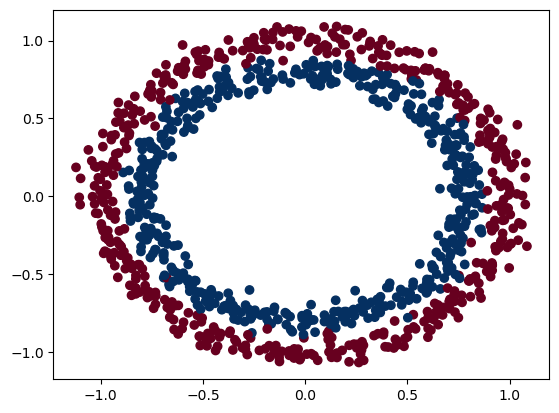

In [46]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu)

In [47]:
x.shape, y.shape

((1000, 2), (1000,))

In [48]:
import torch
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)


In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

## 2. Building a model

In [50]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [51]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
x_train, y_train, x_test, y_test

(tensor([[-0.7607, -0.2504],
         [ 0.2862, -1.0550],
         [ 0.8700, -0.4320],
         ...,
         [ 0.8166, -0.1216],
         [-0.8606,  0.1653],
         [ 0.8517,  0.0717]], device='cuda:0'),
 tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
         1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
         1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
         1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,

In [52]:
class circle_model_v0(nn.Module):
    def __init__(self, input_features=2, hidden_dim=4, output_features=1):
        super(circle_model_v0, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_features)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [54]:
model_0 = circle_model_v0().to(device)
model_0

circle_model_v0(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [55]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=4),
    nn.Linear(in_features=4, out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [56]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0060,  0.3507],
                      [-0.1688,  0.0490],
                      [ 0.5995, -0.4371],
                      [-0.3735,  0.6192]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1773, -0.2150, -0.4913, -0.2940], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0660,  0.0632,  0.2404,  0.2619]], device='cuda:0')),
             ('1.bias', tensor([-0.0316], device='cuda:0'))])

In [59]:
untrained_predict = model_0(x_train)
torch.round(untrained_predict[:5]), y_train[:5]

(tensor([[-0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 0., 0., 1., 0.], device='cuda:0'))